In [1]:
import networkx as nx
import numpy as np
import numpy.linalg as la
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Rectangle

from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib_venn import venn3
import matplotlib.patheffects as pe
from datetime import datetime

import sys
sys.path.append('../mchem_functions/')
import multivariate_functions as mvf
import PCA_functions as pcf

In [2]:
dates = {
    'Aut':'16/10/2024',
    'Win1':'21/01/2025',
    'Win2':'24/02/2025',
    # 'Spr': '15/04/2025'
}

t_points = list(dates.keys())

expl_var_file = 'explanatory_variables.csv'

FMT = r'%d/%m/%Y'

n_dummies = 3
wanted_idx = (np.arange(len(dates)) * n_dummies) + np.arange(len(dates))+1

title_size = 15

In [3]:
def get_time_edges(t_points,n_dummies:int=0):

    edges = []

    if n_dummies != 0:
        a, b = 1, n_dummies+1

        def add_dummy(edges,n_list):
            for i in range(len(n_list)):
                if i == 0:
                    edges += [(edges[-1][-1],f'dummy {n_list[i]}')]
                else:
                    edges += [(f'dummy {n_list[i]-1}',f'dummy {n_list[i]}')]
            return edges

    for i in range(len(t_points)):
        if i == 0:
            edges += [('0',t_points[i])]

        else:
            if n_dummies != 0:
                edges += [(edges[-1][-1],t_points[i])]
            else:
                edges += [(t_points[i-1],t_points[i])]

        if n_dummies != 0 and i != len(t_points)-1:
            add_dummy(edges,np.arange(a,b))
            a,b = a+n_dummies,b+n_dummies

    return edges

def matr_colormesh(arr,x=[],y=[],cmap='viridis',grid=False):
    fig, ax = plt.subplots()

    mappable = ax.pcolormesh(arr,cmap=cmap)
    fig.colorbar(mappable)

    ax.set_ylim(np.max(ax.get_ylim()),np.min(ax.get_ylim()))

    if len(x) != 0:
        locationsx = np.arange(len(x))+0.5
        ax.set_xticks(locationsx, x, rotation=90, ha='center')
    if len(y) != 0:
        locationsy = np.arange(len(y))+0.5
        ax.set_yticks(locationsy, y)

    if grid:
        for i in range(1,np.shape(arr)[0]):
            ax.axhline(i,c='#000',lw=.5)
        for i in range(1,np.shape(arr)[1]):
            ax.axvline(i,c='#000',lw=.5)
def add_ticks(ax,axis,mult=.2,no_of_minorticks=1):
    if axis == 'x':
        ax_set_ticks = ax.set_xticks
        lims = ax.get_xlim()
        lims_range = np.max(lims)-np.min(lims)
        set_minor_ticks = ax.xaxis.set_minor_locator
    elif axis == 'y':
        ax_set_ticks = ax.set_yticks
        lims = ax.get_ylim()
        lims_range = np.max(lims)-np.min(lims)
        set_minor_ticks = ax.yaxis.set_minor_locator

    step = mult*lims_range
    major_ticks = np.arange(np.min(lims),np.max(lims)+step*.2,step)
    ax_set_ticks(major_ticks)
    set_minor_ticks(AutoMinorLocator(no_of_minorticks+1))

In [4]:
edges = get_time_edges(t_points,n_dummies=n_dummies)
nodes = np.array(['0']+list(np.array(edges)[:,1]))

In [5]:
mult = 5
xs = np.arange(1,len(nodes)+1)*mult
pos = []

for i in range(len(nodes)):
    pos.append([xs[i]+mult,0])
pos = np.array(pos)

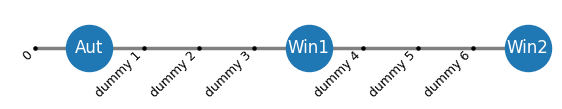

In [6]:
fig_graph, ax_graph = plt.subplots(figsize=(7,1))
dummy_idx = np.where((np.strings.find(nodes, "dummy")==0)|(np.strings.find(nodes, "0")==0))
samples_idx = np.where(~((np.strings.find(nodes, "dummy")==0)|(np.strings.find(nodes, "0")==0)))
ax_graph.plot(pos[:,0],pos[:,1],lw=2.5,zorder=-1,c='gray')
ax_graph.scatter(pos[samples_idx][:,0],pos[samples_idx][:,1],marker='o',s=1100)
ax_graph.scatter(pos[dummy_idx][:,0],pos[dummy_idx][:,1],marker='o',s=5,c='k')

for i in range(len(nodes)):
    if 'dummy' in nodes[i] or '0' in nodes[i]:
        ax_graph.text(pos[i,0],pos[i,1],nodes[i],rotation=45,va='top',ha='right',fontsize=9)
    
    else:
        ax_graph.text(pos[i,0],pos[i,1],nodes[i],va='center',ha='center',c='w',fontsize=12)

# ax_graph.set_title('Temporal Graph for Three Successive Time Points',fontsize=15)

ax_graph.spines['top'].set_visible(False)
ax_graph.spines['right'].set_visible(False)
ax_graph.spines['bottom'].set_visible(False)
ax_graph.spines['left'].set_visible(False)
ax_graph.get_xaxis().set_ticks([])
ax_graph.get_yaxis().set_ticks([])

fig_graph.savefig('aem_graph.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [7]:
E = mvf.nodes_vs_edges_matrix(nodes,edges)

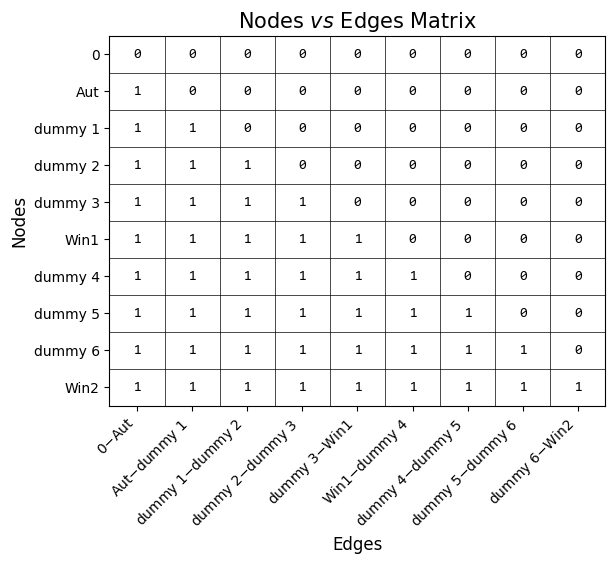

In [8]:
edges_labels = [f'{x[0]}$-${x[1]}' for x in edges]
fig_nve,ax_nve = plt.subplots()

ax_nve.set_ylim(len(nodes),0)
ax_nve.set_xlim(0,len(edges_labels))

for i in range(1,len(edges_labels)+1):
    ax_nve.axhline(i,c='#000',lw=.5)
for i in range(1,len(nodes)):
    ax_nve.axvline(i,c='#000',lw=.5)

locationsx = np.arange(len(edges_labels))+0.5
ax_nve.set_xticks(locationsx, edges_labels, rotation=45, ha='right',va='top')
locationsy = np.arange(len(nodes))+0.5
ax_nve.set_yticks(locationsy, nodes)

for i in range(np.shape(E)[0]):
    for j in range(np.shape(E)[1]):
        ax_nve.text(locationsx[j],locationsy[i],int(E[i,j]),ha='center',va='center',fontfamily='Consolas')

ax_nve.set_xlabel('Edges',fontsize=12)
ax_nve.set_ylabel('Nodes',fontsize=12)
ax_nve.set_title('Nodes $vs$ Edges Matrix',fontsize=15)
fig_nve = plt.gcf()
fig_nve.savefig('NvE.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [9]:
w = []
for i in range(len(t_points)):
    if i != len(t_points)-1:
        t2 = dates[t_points[i+1]]
        t1 = dates[t_points[i]]
        tdelta = datetime.strptime(t2, FMT) - datetime.strptime(t1, FMT)
        tdelta = tdelta.total_seconds() / (86400 * n_dummies) # 86400 s in a day, divide by number of dummies
        w += [tdelta] * (n_dummies+1) # weights must be constructed as similarities, not distances

w = [0] + w
w = np.array(w)
w = 1 - (w / np.sum(w))
w = np.array([w]*len(nodes))

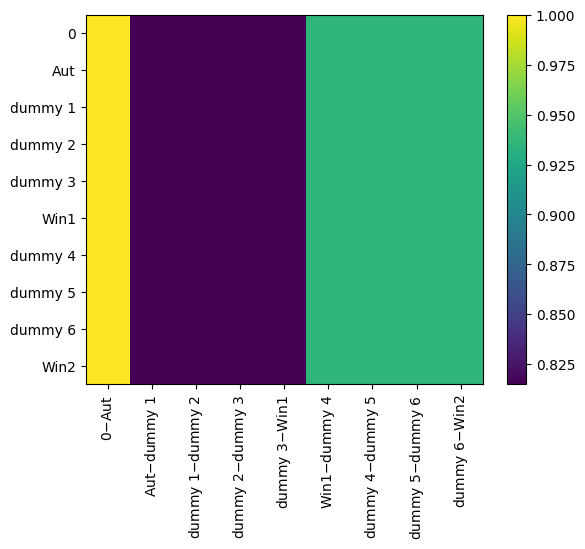

In [10]:
matr_colormesh(w,edges_labels,nodes)

In [11]:
E, eigvals, proportion_explained, U, F = mvf.AEM(E=E,w=w)
E_unweighted, eigvals_unweighted, proportion_explained_unweighted, U_unweighted, F_unweighted = mvf.AEM(E=E)

Text(0.5, 0, 'AEM')

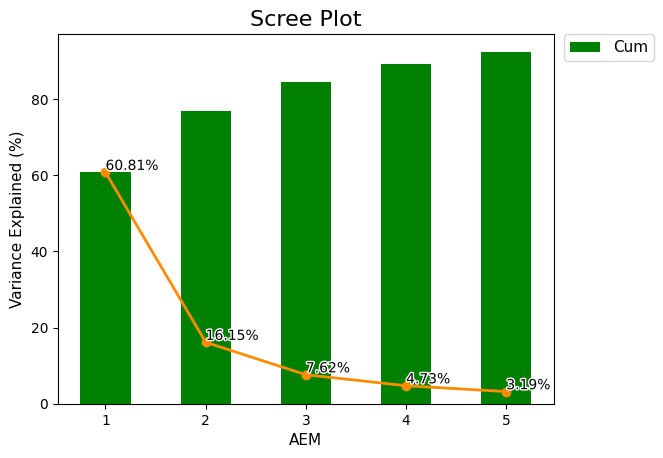

In [12]:
fig_scree, ax_scree = plt.subplots()
pcf.scree_plot(np.arange(1,6),proportion_explained[np.arange(5)],ax=ax_scree)
ax_scree.set_xlabel('AEM')

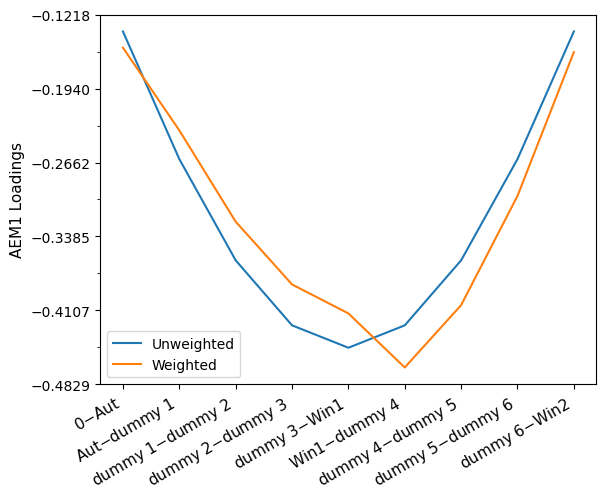

In [16]:
fig_loadings, ax_loadings = plt.subplots()
aem = 1
ax_loadings.plot(np.arange(len(U_unweighted[:,aem-1])),U_unweighted[:,aem-1],label='Unweighted')
ax_loadings.plot(np.arange(len(U[:,aem-1])),U[:,aem-1],label='Weighted')
ax_loadings.legend()
ax_loadings.set_ylabel(f'AEM{aem} Loadings',fontsize=11)
ax_loadings.set_xticks(np.arange(len(U[:,aem-1])), [f'{x[0]}$-${x[1]}' for x in edges],
                       rotation=30, ha='right',fontsize=11)
# ax_loadings.set_title(f'AEM{aem} Loadings Plot for the Weighted and Unweighted AEM',fontsize=16)
add_ticks(ax_loadings,'y')
fig_loadings.savefig('aem_loadingscomparison.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

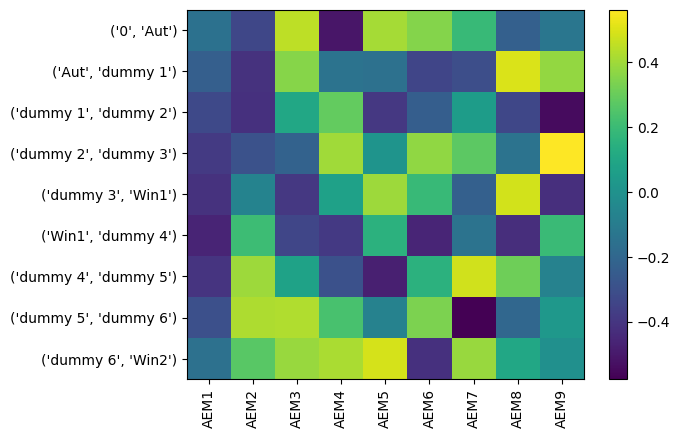

In [80]:
matr_colormesh(U,y=edges,x=[f'AEM{i}' for i in range(1,len(U[0,:])+1)])

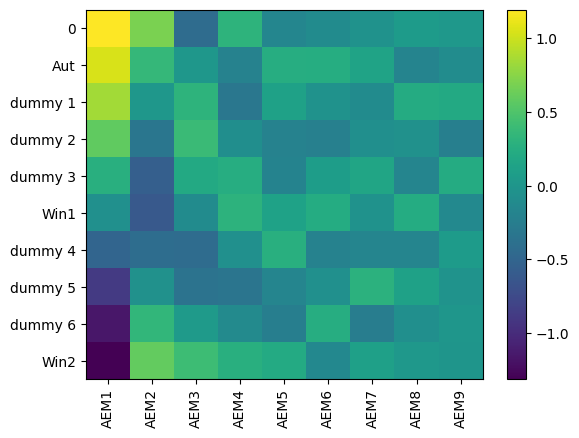

In [81]:
matr_colormesh(F,y=nodes,x=[f'AEM{i}' for i in range(1,len(F[0,:])+1)])

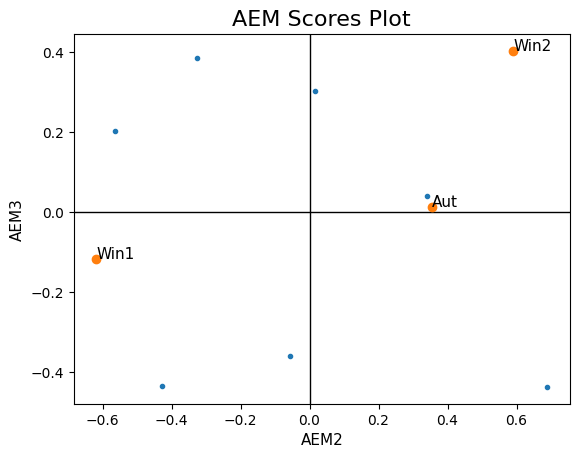

In [82]:
wanted_AEMs = [2,3]
fig_scores, ax_scores = plt.subplots()
pcf.scores_plot(F,wanted_AEMs,ax=ax_scores,marker='.',title='AEM Scores Plot')
ax_scores.set_xlabel(f'AEM{wanted_AEMs[0]}',fontsize=11)
ax_scores.set_ylabel(f'AEM{wanted_AEMs[1]}',fontsize=11)

for i in range(len(wanted_idx)):
    ax_scores.scatter(F[wanted_idx[i],wanted_AEMs[0]-1],F[wanted_idx[i],wanted_AEMs[1]-1],c='tab:orange')
    ax_scores.text(F[wanted_idx[i],wanted_AEMs[0]-1],F[wanted_idx[i],wanted_AEMs[1]-1],t_points[i],fontsize=11)

fig_scores.savefig('aem_scores.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

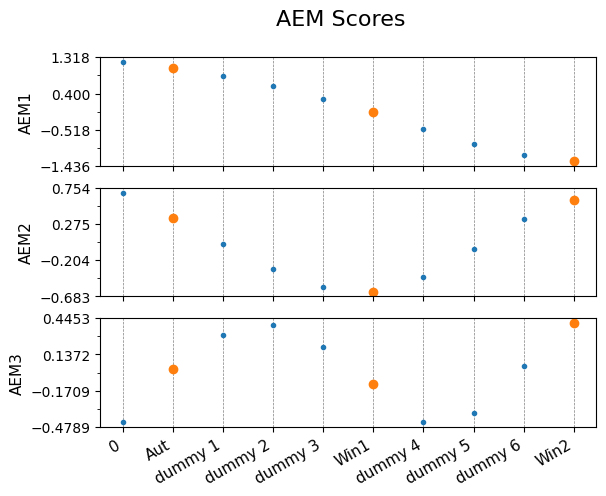

In [15]:
wanted_AEMs = [1,2,3]
fig_aems = plt.figure()
ax_aems = fig_aems.subplots(len(wanted_AEMs),sharex=True)

ticks = np.arange(len(nodes))

for i in range(len(wanted_AEMs)):
    ax_aems[i].scatter(ticks,F[:,wanted_AEMs[i]-1],c='tab:blue',marker='.')
    for j in range(len(wanted_idx)):
        ax_aems[i].scatter(ticks[wanted_idx[j]],F[wanted_idx[j],wanted_AEMs[i]-1],c='tab:orange')
    
    for t in ticks:
        ax_aems[i].axvline(t,ls='--',lw=.5,c='gray',zorder=-1)

    ax_aems[i].set_ylabel(f'AEM{wanted_AEMs[i]}',fontsize=11)
    add_ticks(ax_aems[i],'y',mult=1/3)

ax_aems[-1].set_xticks(ticks)
ax_aems[-1].set_xticklabels(nodes,rotation=30,ha='right',fontsize=11)

fig_aems.suptitle('AEM Scores',fontsize=16)

fig_aems.savefig('aem_scores_multi.svg', dpi = 600, facecolor = '#fff', bbox_inches='tight')

In [84]:
# Only get the scores we are interested in (see dates)
F_wanted = F[wanted_idx,:]

In [85]:
# Save the scores in a CSV file so that they can be retrieved for RDA
expl_var = pd.read_csv(expl_var_file,index_col=None)

aem_csv_col = []
for i in range(np.shape(F_wanted)[0]):
    aem_csv_col += [F_wanted[i]]*int(len(expl_var)/np.shape(F_wanted)[0])
expl_var['AEM'] = aem_csv_col

expl_var.to_csv(expl_var_file,index=False)